## Load and Prepare Data

In [335]:
import benchmax.evaluation as ev
from os.path import exists
#import tikzplotlib
import pandas as pd

def process_memouts(df,memout = 4000000,timeout=60):
    for s in ev.get_solvers(df):
        df.loc[(df[(s, 'answer')] == 'segfault') & (df[(s,'peak_memory_kbytes')]>memout), (s, 'answer')] = 'memout'
        df.loc[(df[(s, 'answer')] == 'memout'), (s, 'runtime')] = timeout+6
        df.loc[(df[(s, 'answer')] == 'timeout'), (s, 'runtime')] = timeout+3
    return df

def compute_poly_count(df, s):
    df[(s,'smtrat-cadcells_projections.poly_count')] = df[(s,'smtrat-cadcells_projections.coefficient.level.count')] + df[(s,'smtrat-cadcells_projections.discriminant.level.count')] + df[(s,'smtrat-cadcells_projections.factor.level.count')] + df[(s,'smtrat-cadcells_projections.leading_coefficient.level.count')] + df[(s,'smtrat-cadcells_projections.resultant.level.count')]
    df[(s,'smtrat-cadcells_projections.discres.poly_count')] = df[(s,'smtrat-cadcells_projections.discriminant.level.count')] + df[(s,'smtrat-cadcells_projections.resultant.level.count')]

def compute_poly_total_degree(df, s):
    df[(s,'smtrat-cadcells_projections.poly.total_degree.sum')] = df[(s,'smtrat-cadcells_projections.coefficient.total_degree.sum')] + df[(s,'smtrat-cadcells_projections.discriminant.total_degree.sum')] + df[(s,'smtrat-cadcells_projections.factor.total_degree.sum')] + df[(s,'smtrat-cadcells_projections.leading_coefficient.total_degree.sum')] + df[(s,'smtrat-cadcells_projections.resultant.total_degree.sum')]
    df[(s,'smtrat-cadcells_projections.poly.total_degree.count')] = df[(s,'smtrat-cadcells_projections.coefficient.total_degree.count')] + df[(s,'smtrat-cadcells_projections.discriminant.total_degree.count')] + df[(s,'smtrat-cadcells_projections.factor.total_degree.count')] + df[(s,'smtrat-cadcells_projections.leading_coefficient.total_degree.count')] + df[(s,'smtrat-cadcells_projections.resultant.total_degree.count')]
    df[(s,'smtrat-cadcells_projections.poly.total_degree.avg')] = df[(s,'smtrat-cadcells_projections.poly.total_degree.sum')] / df[(s,'smtrat-cadcells_projections.poly.total_degree.count')]
    df[(s,'smtrat-cadcells_projections.poly.total_degree.max')] = df[[(s,'smtrat-cadcells_projections.coefficient.total_degree.max'),(s,'smtrat-cadcells_projections.discriminant.total_degree.max'),(s,'smtrat-cadcells_projections.factor.total_degree.max'),(s,'smtrat-cadcells_projections.leading_coefficient.total_degree.max'),(s,'smtrat-cadcells_projections.resultant.total_degree.max')]].max(axis=1)

def compute_multicounter_total(df, s, in_field, out_field, cond = lambda s : True):
    def func(row):
        if not isinstance(row[(s,in_field)], str):
            return 0
        sum = 0
        for pair in row[(s,in_field)].split(';')[:-1]:
            if cond(pair.split('=')[0]):
                sum = sum + int(pair.split('=')[1])
        return sum
    df[(s,out_field)] = df.apply(func, axis=1, result_type='reduce')


if exists('data.csv'):
    print("Load data.csv")
    stats = ev.csv_to_pandas('data.csv')
else: 
    print("Generate data.csv")

    stats = ev.csv_to_pandas('stats_smtrat-dev_off_24-04-08_13:20.csv')
    stats = stats.join(ev.csv_to_pandas('stats_smtrat-dev_off_24-04-12_11:56.csv'))

    stats = process_memouts(stats)

    for s in ev.get_solvers(stats):
        stats[(s, 'solved')] = stats[(s, 'answer')].isin(['sat','unsat'])

        stats[(s, 'mcsat-explanation-timer.overall_ms')] = stats[(s, 'mcsat-explanation-onecell_timer.overall_ms')] + stats[(s, 'mcsat-explanation-nlsat_timer.overall_ms')]
        stats[(s, 'mcsat-other-timer.overall_ms')] = stats[(s, 'runtime')]-stats[(s, 'mcsat-explanation-timer.overall_ms')]

        stats[(s, 'smtrat-cadcells_filter.timer.filter_roots_inverse.overall_ms')] = stats[(s, 'smtrat-cadcells_projections.timer.overall_ms')]-stats[(s, 'smtrat-cadcells_filter.timer.filter_roots.overall_ms')]
        stats[(s, 'mcsat-explanation-onecell_explanation_failed')] = stats[(s, 'mcsat-explanation-onecell_explanation_called')]-stats[(s, 'mcsat-explanation-onecell_explanation_success')]
        compute_poly_count(stats,s)
        compute_poly_total_degree(stats,s)
        stats[(s,'smtrat-cadcells_filter.poly_count')] = stats[(s,'smtrat-cadcells_filter.poly_count.by_depth.total')]
        stats[(s,'smtrat-cadcells_filter.poly_count.independent')] = stats[(s,'smtrat-cadcells_filter.poly_count.independent.by_depth.total')]
        
        compute_multicounter_total(stats, s, 'smtrat-cadcells_filter.poly_count.by_depth_and_num_factors', 'smtrat-cadcells_filter.poly_count.irreducible', lambda s : s[1:-1].split(',')[1] == '1')

        stats[(s,'smtrat-cadcells_filter.root')] = stats[(s,'smtrat-cadcells_filter.root.by_depth.total')]

        stats[(s,'smtrat-cadcells_heuristics.representation.roots_inside.relative')] = stats[(s,'smtrat-cadcells_heuristics.representation.roots_inside.by_depth.total')] / stats[(s,'smtrat-cadcells_filter.root.by_depth.total')]


        stats[(s,'smtrat-cadcells_filter.root.optional')] = stats[(s,'smtrat-cadcells_filter.root.optional.by_depth.total')]
        stats[(s,'smtrat-cadcells_filter.poly_count.has_zeros_irred_indep')] = stats[(s,'smtrat-cadcells_filter.poly_count.has_zeros_irred_indep.by_depth.total')]

        stats[(s,'smtrat-cadcells_filter.poly_count.has_zeros_irred_indep.relative')] = stats[(s,'smtrat-cadcells_filter.poly_count.has_zeros_irred_indep.by_depth.total')] / stats[(s,'smtrat-cadcells_filter.poly_count')]
 

    stats.to_csv("data.csv")

Load data.csv


/home/jnalbach/vc/paper/paper-irrelevant-roots/evaluation/venv/lib64/python3.9/site-packages/benchmax/evaluation/load.py:100: DtypeWarning: Columns (14,80,82,96,121,227,291,293,295,303,306,309,334,440,506,508,522,547,653,717,719,721,729,732,735,760,866,930,932,934,942,945,948,973,1079,1143,1145,1147,1155,1158,1161,1186,1292,1356,1358,1360,1368,1371,1374,1399,1505,1569,1571,1573,1581,1584,1587,1612,1718,1784,1786,1800,1809,1827) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(filename, header=[0,1], index_col=0)


In [336]:

# Filter for instances where the theory bakcend has been called at least once
stats = stats[(stats[('smtrat-Filter_BCNoop-development','mcsat-explanation-onecell_explanation_called')]>0) | ~stats[('smtrat-Filter_BCNoop-development','answer')].isin(['sat','unsat'])]

stats_renamed = ev.filter_solvers(stats, only=['smtrat-Filter_BCNoop-development', 'smtrat-Filter_BCAll-development','smtrat-Filter_BCIrredIndep-development','smtrat-Filter_BCRational-development','smtrat-Filter_BCBoundsOnlyIntersect-development'])
stats_renamed = ev.rename_solvers(stats_renamed, {
    'smtrat-Filter_BCNoop-development': 'Baseline',
    'smtrat-Filter_BCAll-development': 'All',
    'smtrat-Filter_BCIrredIndep-development': 'Independent',
    'smtrat-Filter_BCRational-development': 'Rational',
    'smtrat-Filter_BCBoundsOnlyIntersect-development': 'Bounds'
})

## Performance Profile of All Variants

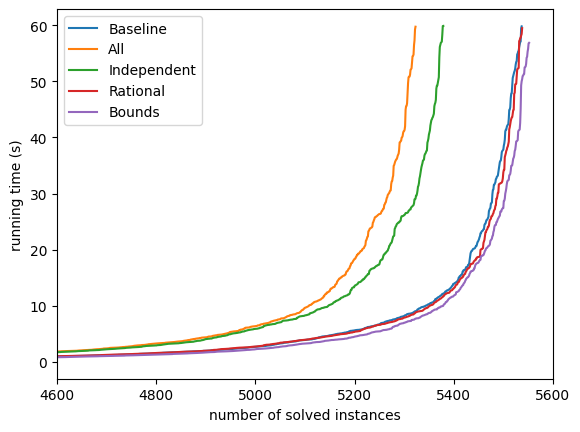

In [363]:
ms_to_s = lambda x: x / 1_000

def transform_ms_to_s(df):
    df = df.copy()
    for s in ev.get_solvers(df):
       df[(s,'runtime')] = df[(s,'runtime')] / 1000
    return df

    
plot = ev.performance_profile(transform_ms_to_s(stats_renamed), ev.get_solvers(stats_renamed))
plot.axes.legend(['Baseline', 'All', 'Independent', 'Rational', 'Bounds'])
plot.set_xlim(4600,5600)
plot.set_xlabel('number of solved instances')
plot.set_ylabel('running time (s)')
#tikzplotlib.save('fig/eval-performance-profile.tex')


## Gained and Lost Instances 

In [338]:
data = []
baseline = 'Baseline'
solvers = ['All','Independent','Rational','Bounds']

for s in solvers:
    gained = ev.filter(stats_renamed,solved_by=[s],not_solved_by=[baseline]).shape[0]
    lost = ev.filter(stats_renamed,not_solved_by=[s],solved_by=[baseline]).shape[0]
    data.append((s,gained,lost,gained-lost))

res = pd.DataFrame(data,columns=['','gained instances', 'lost instances', 'total difference instances'])
res = res.set_index([''])
#res.index = (['All','Independent','Rational','Bounds'])
#res.to_latex('fig/eval-instances-table.tex')
res

gained instances  lost instances  total difference instances
                                                                         
All                        53             267                        -214
Independent                 9             167                        -158
Rational                   42              41                           1
Bounds                     85              70                          15

## Measures in Detail

In [339]:
def compare_field(df, field, solvers = None, filter_mode = 'common', percentiles = [0,.1,.2,.3,.4,.5,.6,.7,.8,.9,1]):
    if not solvers:
        solvers = ev.get_solvers(df)

    if filter_mode == 'individual':
        df = df.copy()
        for s in solvers:
            df.loc[~df[(s,'answer')].isin(['sat','unsat']), (s,field)] = None
    elif filter_mode == 'common':
        df = ev.filter(df, solved_by=solvers)


    drop = ['count','min','max','std','mean']
    if .5 not in percentiles:
        drop.append('50%')

    ax = df[[(s,field) for s in solvers]].describe(percentiles=percentiles).T.drop(drop, axis=1).plot(kind='bar')
    ax.set_xticks(range(0,len(solvers)),labels=solvers)
    ax.legend(bbox_to_anchor=(1,1))
    #ax.legend().remove()

    #ax = df[[(s,field) for s in solvers]].plot.box()
    #ax.set_xticks(range(1,len(solvers)+1),labels=solvers)

    ax.set_title(field)

    df1 = df[[(s,field) for s in solvers]].describe(percentiles=percentiles)
    for s in solvers:
        df1.loc['num', s] = df.shape[0]
        df1.loc['sum', s] = df[(s,field)].sum()
        df1.loc['avg', s] = df[(s,field)].sum() / df.shape[0]

    return (df1,ax)

In [340]:
stats_renamed_filtered = ev.filter(stats_renamed,solved_by=ev.get_solvers(stats_renamed))

### Number of Resultant Roots used for Merging (All, Independent, Rational)

In [341]:
for s in ev.get_solvers(stats_renamed):
    print(s, stats_renamed_filtered[(s,'smtrat-cadcells_heuristics.representation.roots_inside.by_depth.total')].sum() / stats_renamed_filtered[(s,'smtrat-cadcells_filter.root.by_depth.total')].sum())

Baseline 0.0
All 0.030321126680458693
Independent 0.0008410881662259365
Rational 0.0074456134582716865
Bounds 0.0


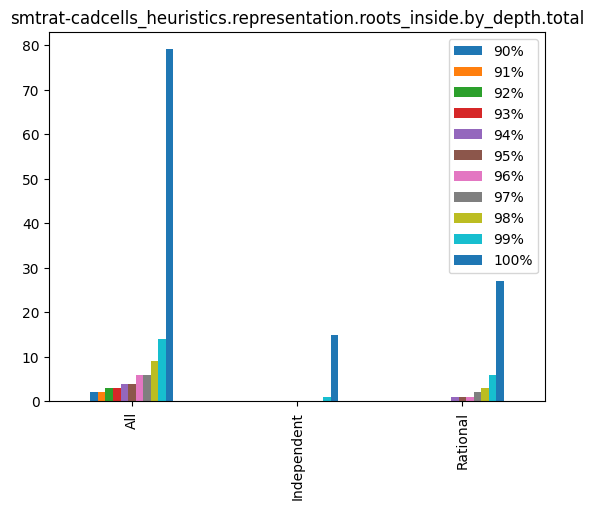

In [342]:
(df1,ax) = compare_field(stats_renamed_filtered, 'smtrat-cadcells_heuristics.representation.roots_inside.by_depth.total', percentiles=[.9,.91,.92,.93,.94,.95,.96,.97,.98,.99,1], solvers=['All','Independent','Rational'])

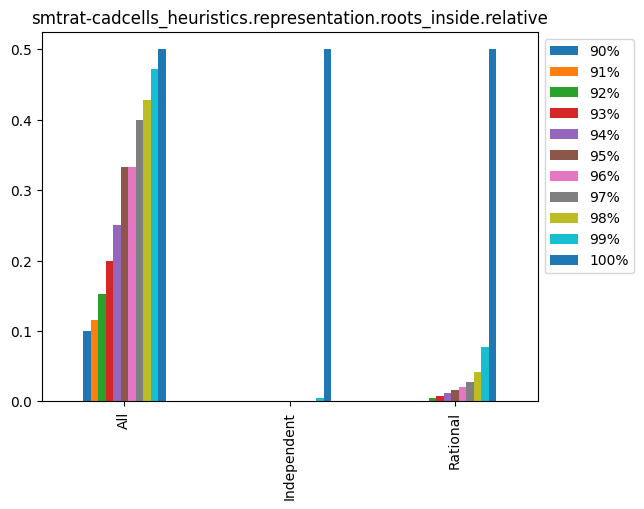

In [343]:
(df1,ax) = compare_field(stats_renamed_filtered, 'smtrat-cadcells_heuristics.representation.roots_inside.relative', percentiles=[.9,.91,.92,.93,.94,.95,.96,.97,.98,.99,1], solvers=['All','Independent','Rational'])

#### Impact on Cell Quality (Time Spent outside the Theory Solver)

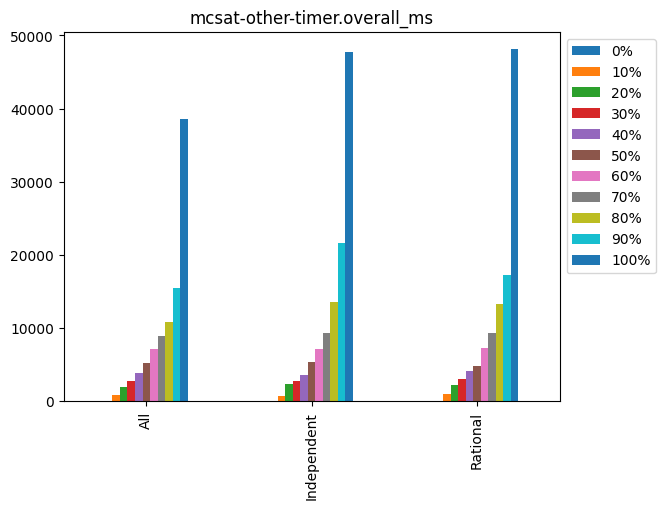

In [344]:
(df1,ax) = compare_field(stats_renamed_filtered[stats_renamed_filtered[('All','smtrat-cadcells_heuristics.representation.roots_inside.by_depth.total')]>0], 'mcsat-other-timer.overall_ms', solvers=['All','Independent','Rational'])

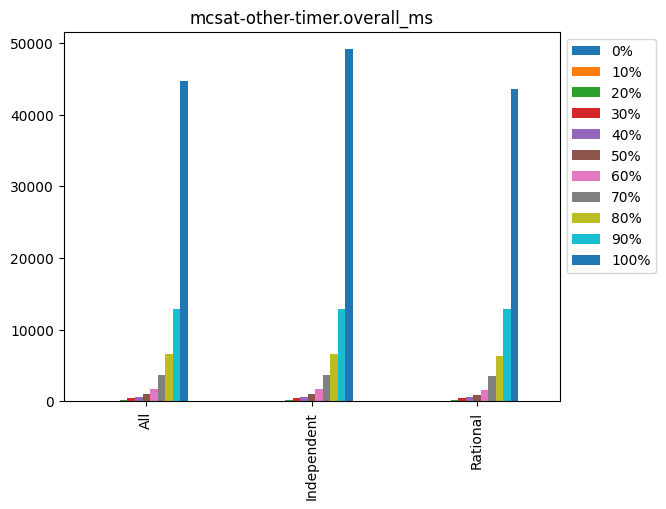

In [345]:
(df1,ax) = compare_field(stats_renamed[stats_renamed[('All','smtrat-cadcells_heuristics.representation.roots_inside.by_depth.total')]==0], 'mcsat-other-timer.overall_ms', solvers=['All','Independent','Rational'])

In [346]:
data = []
df = stats_renamed_filtered
condition = stats_renamed_filtered[('All','smtrat-cadcells_heuristics.representation.roots_inside.by_depth.total')]>0
field = 'mcsat-other-timer.overall_ms'
solvers = ['Baseline','All']

for s in solvers:
    data.append((s,df[condition][(s,field)].sum() / df[condition].shape[0]/1000, df[~condition][(s,field)].sum() / df[~condition].shape[0]/1000))

data.append(('count', df[condition].shape[0], df[~condition].shape[0]))

res = pd.DataFrame(data,columns=['','>0 merge','no merge'])
res = res.set_index([''])
#res.to_latex('fig/eval-instances-table.tex')
res


>0 merge     no merge
                                  
Baseline     1.083866     0.213883
All          0.896614     0.209917
count     1002.000000  4208.000000

In [347]:
data = []
df = stats_renamed_filtered
condition = stats_renamed_filtered[('Independent','smtrat-cadcells_heuristics.representation.roots_inside.by_depth.total')]>0
field = 'mcsat-other-timer.overall_ms'
solvers = ['Baseline','Independent']

for s in solvers:
    data.append((s,df[condition][(s,field)].sum() / df[condition].shape[0]/1000, df[~condition][(s,field)].sum() / df[~condition].shape[0]/1000))

data.append(('count', df[condition].shape[0], df[~condition].shape[0]))

res = pd.DataFrame(data,columns=['','>0 merge','no merge'])
res = res.set_index([''])
#res.to_latex('fig/eval-instances-table.tex')
res

>0 merge     no merge
                                   
Baseline      4.122117     0.337617
Independent   4.122617     0.337113
count        60.000000  5150.000000

In [348]:
data = []
df = stats_renamed_filtered
condition = stats_renamed_filtered[('Rational','smtrat-cadcells_heuristics.representation.roots_inside.by_depth.total')]>0
field = 'mcsat-other-timer.overall_ms'
solvers = ['Baseline','Rational']

for s in solvers:
    data.append((s,df[condition][(s,field)].sum() / df[condition].shape[0]/1000, df[~condition][(s,field)].sum() / df[~condition].shape[0]/1000))

data.append(('count', df[condition].shape[0], df[~condition].shape[0]))

res = pd.DataFrame(data,columns=['','>0 merge','no merge'])
res = res.set_index([''])
#res.to_latex('fig/eval-instances-table.tex')
res

>0 merge     no merge
                                
Baseline    2.79153     0.207085
Rational    2.63106     0.203094
count     351.00000  4859.000000

### Time for Checking for Irrelvant Roots (All, Independent, Rational)

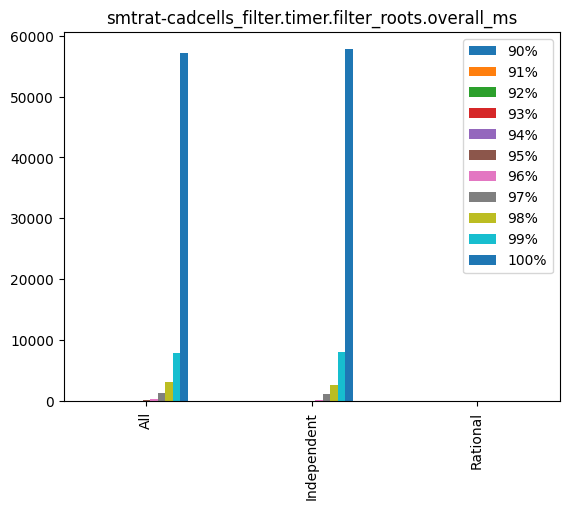

In [349]:
(df1,ax) = compare_field(stats_renamed_filtered, 'smtrat-cadcells_filter.timer.filter_roots.overall_ms', percentiles=[.9,.91,.92,.93,.94,.95,.96,.97,.98,.99,1], solvers=['All','Independent','Rational'])

In [350]:
data = []
df = stats_renamed_filtered
field1 = 'smtrat-cadcells_filter.timer.filter_roots.overall_ms'
field2 = 'runtime'
solvers = ['Baseline','All','Independent','Rational']

for s in solvers:
    data.append((s,df[(s,field1)].sum() / df[(s,field2)].sum()))

data.append(('count', df.shape[0]))

res = pd.DataFrame(data,columns=['','relative time'])
res = res.set_index([''])
#res.to_latex('fig/eval-instances-table.tex')
res

relative time
                          
Baseline          0.000002
All               0.254281
Independent       0.246069
Rational          0.000004
count          5210.000000

#### Timeouts During Checks for Irrelevant Roots (on all benchmarks)

In [351]:
data = []
df = stats_renamed
field = 'smtrat-cadcells_filter.timer.filter_roots.active_at_timeout'
solvers = ['Baseline','All','Independent','Rational']

for s in solvers:
    data.append((s,df[(s,field)].sum()))

data.append(('count', df.shape[0]))

res = pd.DataFrame(data,columns=['','num active_at_timeout'])
res = res.set_index([''])
#res.to_latex('fig/eval-instances-table.tex')
#print(res.to_latex())
res

num active_at_timeout
                                  
Baseline                       0.0
All                          452.0
Independent                  344.0
Rational                       0.0
count                       7615.0

### Number of Resultants that are Independent and Irreducible (Independent)

In [352]:
data = []
df = stats_renamed_filtered
field1 = 'smtrat-cadcells_filter.poly_count.irreducible'
field2 = 'smtrat-cadcells_filter.poly_count.has_zeros_irred_indep'
fieldbase = 'smtrat-cadcells_filter.poly_count'

solvers = ['Baseline','All','Independent']

for s in solvers:
    data.append((s,df[(s,field1)].sum() / df[(s,fieldbase)].sum(), df[(s,field2)].sum() / df[(s,fieldbase)].sum()))


res = pd.DataFrame(data,columns=['','irreducible','irreducible and indepdendent and more than one root'])
res = res.set_index([''])
#res.to_latex('fig/eval-instances-table.tex')
#print(res.to_latex())
res

irreducible  irreducible and indepdendent and more than one root
                                                                             
Baseline        0.812454                                           0.000000  
All             0.807952                                           0.005559  
Independent     0.812270                                           0.006558

### Number of Algebraic Roots (Rational)

In [353]:
data = []
df = stats_renamed_filtered
field1 = 'smtrat-cadcells_filter.root.sample_algebraic.by_depth.total'
field2 = 'smtrat-cadcells_filter.root.algebraic.by_depth.total'
fieldbase = 'smtrat-cadcells_filter.root.by_depth.total'

solvers = ['Rational']

for s in solvers:
    data.append((s,df[(s,field1)].sum() / df[(s,fieldbase)].sum(), df[(s,field2)].sum() / df[(s,fieldbase)].sum()))


res = pd.DataFrame(data,columns=['','roots which are algebraic or their underyling sample point is', 'algebraic roots'])
res = res.set_index([''])
#res.to_latex('fig/eval-instances-table.tex')
#print(res.to_latex())
res


roots which are algebraic or their underyling sample point is  \
                                                                          
Rational                                           0.319997               

          algebraic roots  
                           
Rational         0.244952

### Number of of Bounds used for Merging (Bounds)

In [354]:
data = []
df = stats_renamed_filtered

solvers = ['Bounds']

for s in solvers:
    df[(s,'smtrat-cadcells_heuristics.interval.has_closed_count')]=df[(s,'smtrat-cadcells_heuristics.interval.closed_count.by_depth.total')] + df[(s,'smtrat-cadcells_heuristics.interval.halfclosed_count.by_depth.total')]
    #df[(s,'smtrat-cadcells_heuristics.interval.has_closed_count')] = df[(s,'smtrat-cadcells_heuristics.interval.closed_count.by_depth.total')] - df[(s,'smtrat-cadcells_heuristics.interval.point_count.by_depth.total')] + df[(s,'smtrat-cadcells_heuristics.interval.halfopen_count.by_depth.total')] - df[(s,'smtrat-cadcells_heuristics.interval.unbounded_count.by_depth.total')] - df[(s,'smtrat-cadcells_heuristics.interval.halfunbounded_count.by_depth.total')]
    #df[(s,'smtrat-cadcells_heuristics.interval.count.by_depth.total')] = df[(s,'smtrat-cadcells_heuristics.interval.closed_count.by_depth.total')] + df[(s,'smtrat-cadcells_heuristics.interval.halfopen_count.by_depth.total')] + df[(s,'smtrat-cadcells_heuristics.interval.open_count.by_depth.total')]

    closed = df[(s,'smtrat-cadcells_heuristics.interval.has_closed_count')].sum()
    total = df[(s,'smtrat-cadcells_heuristics.interval.count.by_depth.total')].sum() - df[(s,'smtrat-cadcells_heuristics.interval.point_count.by_depth.total')].sum()
    total2 = df[(s,'smtrat-cadcells_heuristics.interval.count.by_depth.total')].sum()
    data.append((s,closed/total,closed/total2,df[(s,'smtrat-cadcells_heuristics.interval.point_count.by_depth.total')].sum()/total2))


res = pd.DataFrame(data,columns=['','closed/totalnonsections','closed/total','sections/total'])
res = res.set_index([''])
#res.to_latex('fig/eval-instances-table.tex')
#print(res.to_latex())
res

closed/totalnonsections  closed/total  sections/total
                                                             
Bounds                 0.020302      0.019727         0.02831

#### Impact on Cell Quality (Time Spent outside the Theory Solver)

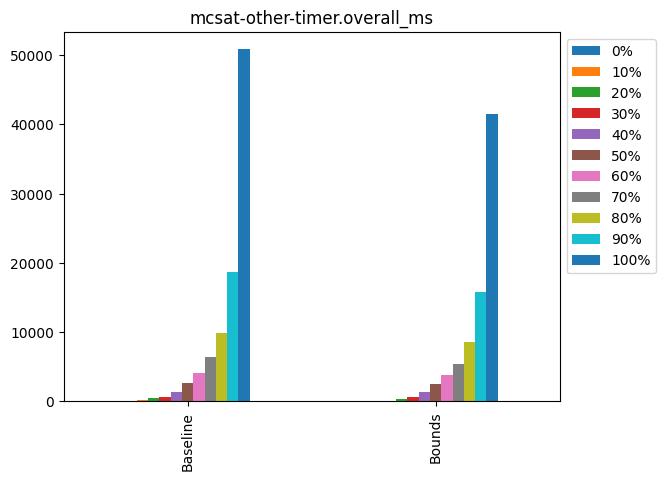

In [355]:
(df1,ax) = compare_field(stats_renamed_filtered[stats_renamed_filtered[('Bounds','smtrat-cadcells_heuristics.interval.has_closed_count')]>0], 'mcsat-other-timer.overall_ms',solvers=['Baseline','Bounds'])

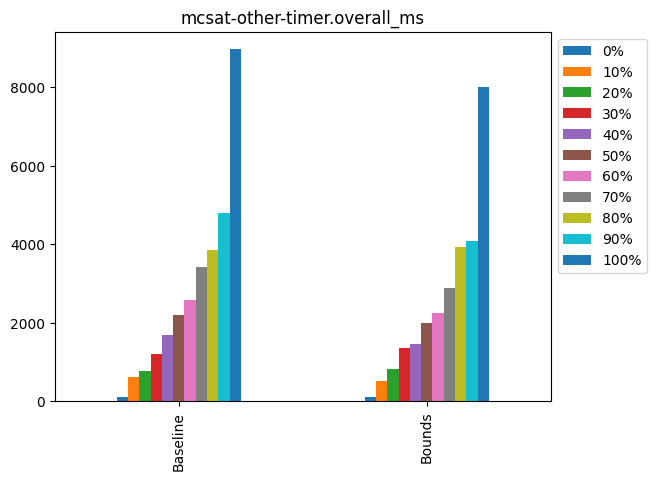

In [356]:
(df1,ax) = compare_field(stats_renamed_filtered[stats_renamed_filtered[('Bounds','smtrat-cadcells_heuristics.interval.has_closed_count')]==0], 'mcsat-other-timer.overall_ms',solvers=['Baseline','Bounds'])

In [357]:
data = []
df = stats_renamed_filtered
condition = stats_renamed_filtered[('Bounds','smtrat-cadcells_heuristics.interval.has_closed_count')]>0
field = 'mcsat-other-timer.overall_ms'
solvers = ['Baseline','Bounds']

for s in solvers:
    data.append((s,df[condition][(s,field)].sum() / df[condition].shape[0]/1000, df[~condition][(s,field)].sum() / df[~condition].shape[0]/1000, df[(s,field)].sum() / df.shape[0]/1000))

data.append(('count', df[condition].shape[0], df[~condition].shape[0], df.shape[0]))

res = pd.DataFrame(data,columns=['','>0 merge','no merge', 'all'])
res = res.set_index([''])
#res.to_latex('fig/eval-instances-table.tex')
#print(res.to_latex())
res

>0 merge     no merge          all
                                               
Baseline     0.480436     0.026515     0.381201
Bounds       0.423622     0.024102     0.336280
count     4071.000000  1139.000000  5210.000000

#### Impact on Cell Quality (Number of Sections) 

In [358]:
data = []
df = stats_renamed_filtered
condition = stats_renamed_filtered[('Bounds','smtrat-cadcells_heuristics.interval.has_closed_count')]>0
field = 'smtrat-cadcells_heuristics.section.count'
solvers = ['Baseline','Bounds']

for s in solvers:
    data.append((s,df[condition][(s,field)].sum() / df[condition].shape[0]/1000, df[~condition][(s,field)].sum() / df[~condition].shape[0]/1000, df[(s,field)].sum() / df.shape[0]/1000))

data.append(('count', df[condition].shape[0], df[~condition].shape[0], df.shape[0]))

res = pd.DataFrame(data,columns=['','>0 merge','no merge', 'all'])
res = res.set_index([''])
#res.to_latex('fig/eval-instances-table.tex')
#print(res.to_latex())
res

>0 merge     no merge          all
                                               
Baseline     0.028669     0.001305     0.022687
Bounds       0.023049     0.001305     0.018295
count     4071.000000  1139.000000  5210.000000

#### By Level

In [359]:
def extract_level_data(df, s, in_field):
    res = pd.DataFrame(columns=['count'])

    def func(row):
        if not isinstance(row[(s,in_field)], str):
            return
        for pair in row[(s,in_field)].split(';')[:-1]:
            if pair.split('=')[0] not in res:
                res.loc[pair.split('=')[0],'count'] = 0
            res.loc[pair.split('=')[0],'count'] = res.loc[pair.split('=')[0],'count'] + int(pair.split('=')[1])
    df.apply(func, axis=1)

    return res

count = extract_level_data(stats_renamed_filtered, 'Bounds', 'smtrat-cadcells_heuristics.interval.count.by_depth')
closed_count = extract_level_data(stats_renamed_filtered, 'Bounds', 'smtrat-cadcells_heuristics.interval.closed_count.by_depth')
halfclosed_count = extract_level_data(stats_renamed_filtered, 'Bounds', 'smtrat-cadcells_heuristics.interval.halfclosed_count.by_depth')

In [360]:
rel = count.rename(columns={'count': 'total'}).join(closed_count.rename(columns={'count': 'closed'}).join(halfclosed_count.rename(columns={'count': 'halfclosed'}), how='outer'), how='outer')
rel['has_closed'] = rel['closed'].add(rel['halfclosed'],fill_value=0).fillna(0)
rel['rel_level'] = rel['has_closed'] / rel['total']
rel['rel_total'] = rel['has_closed'] / stats_renamed_filtered[('Bounds','smtrat-cadcells_heuristics.interval.count.by_depth.total')].sum()

rel.index = rel.index.astype(int)

rel

/tmp/ipykernel_10206/2697538777.py:2: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  rel['has_closed'] = rel['closed'].add(rel['halfclosed'],fill_value=0).fillna(0)


total closed halfclosed  has_closed rel_level     rel_total
0    2694      3        331         334  0.123979  9.919913e-05
1    1329      2         29          31  0.023326  9.207105e-06
10   1040      1          2           3  0.002885  8.910102e-07
100    21    NaN          1           1  0.047619  2.970034e-07
101    20    NaN        NaN           0       0.0  0.000000e+00
..    ...    ...        ...         ...       ...           ...
95     23    NaN        NaN           0       0.0  0.000000e+00
96     23    NaN        NaN           0       0.0  0.000000e+00
97     22    NaN        NaN           0       0.0  0.000000e+00
98     21    NaN        NaN           0       0.0  0.000000e+00
99     21    NaN          1           1  0.047619  2.970034e-07

[256 rows x 6 columns]

### Cell Quality and Effort in Theory Solver

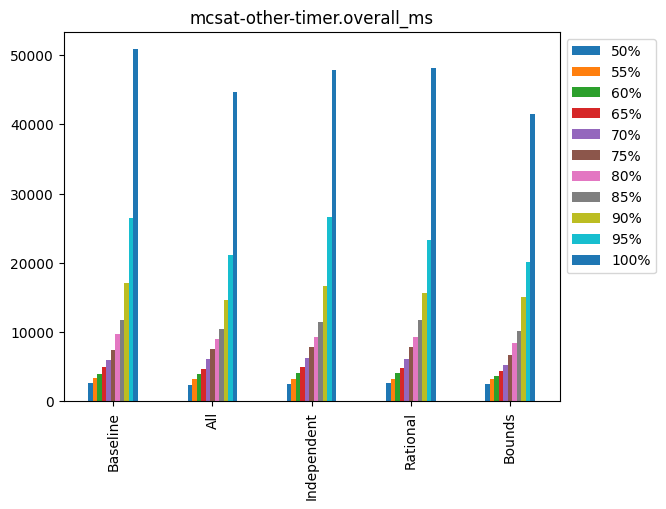

In [361]:
(df1,ax) = compare_field(stats_renamed, 'mcsat-other-timer.overall_ms', percentiles=[.5,.55,.6,.65,.7,.75,.8,.85,.9,.95,1])

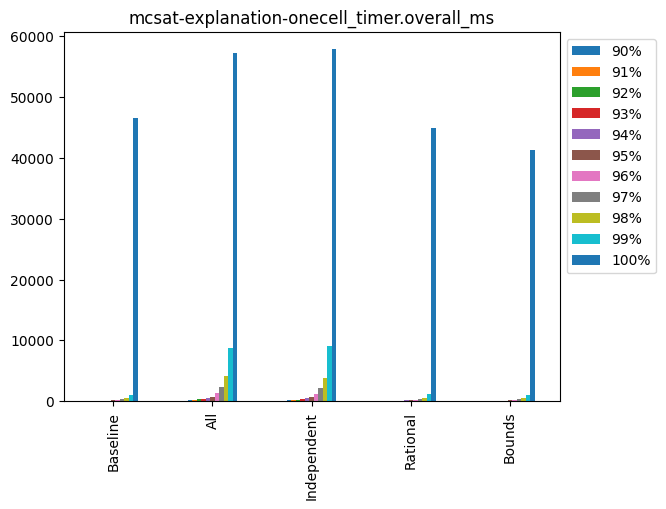

In [362]:
(df1,ax) = compare_field(stats_renamed, 'mcsat-explanation-onecell_timer.overall_ms',percentiles=[.9,.91,.92,.93,.94,.95,.96,.97,.98,.99,1])